In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, f1_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# All models
all_models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression (Degree 2)": PolynomialFeatures(degree=2),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=100, depth=5, learning_rate=0.05, random_state=42, verbose=0),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "Ridge Regression": Ridge(alpha=1.0),
    "Multiple Linear Regression (MLR)": LinearRegression()
}

stl_path = "../processed_data/STL/stl_energy_production_with_engineered_features.csv"
hp_path = "../processed_data/HP/hp_energy_production_with_engineered_features.csv"

stl_df = pd.read_csv(stl_path)
hp_df = pd.read_csv(hp_path)

def prepare_data(df, target_col="Normalized_Efficiency", train_ratio=0.8):
    df = df.sort_values("Date").dropna(subset=[target_col]).reset_index(drop=True)

    df = df.drop(columns=["Station", "Date"], errors="ignore")
    cutoff = int(len(df) * train_ratio)
    

    train_df = df.iloc[:cutoff].copy()
    test_df  = df.iloc[cutoff:].copy()


    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]


    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test


def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    if name == "Polynomial Regression (Degree 2)":
        poly = PolynomialFeatures(degree=2)
        X_train = poly.fit_transform(X_train)
        X_test = poly.transform(X_test)
        model = LinearRegression()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        "Model": name,
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae
    }


In [25]:
def run_models(dataset_name, df, target_col, model_dict):
    X_train, X_test, y_train, y_test = prepare_data(df, target_col)
    results = []

    print(f" Running models for: {dataset_name}")
    for name, model in model_dict.items():
        res = evaluate_model(name, model, X_train, X_test, y_train, y_test)
        results.append(res)
        print(f"{name} → R²: {res['R2']:.3f}, RMSE: {res['RMSE']:.3f}, MAE: {res['MAE']:.3f}")

    results_df = pd.DataFrame(results)
    csv_path = f"../processed_data/{dataset_name.lower()}_ml_metrics.csv"
    results_df.to_csv(csv_path, index=False)

    return results_df.sort_values(by="RMSE"), results_df.sort_values(by="R2", ascending=False)

In [26]:
stl_rmse_sorted, stl_r2_sorted = run_models("STL", stl_df, "Normalized_Efficiency", all_models)
hp_rmse_sorted, hp_r2_sorted = run_models("HP", hp_df, "Normalized_Efficiency", all_models)

 Running models for: STL
Linear Regression → R²: -0.186, RMSE: 163.070, MAE: 5.783
Polynomial Regression (Degree 2) → R²: -565.729, RMSE: 3565.034, MAE: 101.931
Decision Tree → R²: -0.000, RMSE: 149.757, MAE: 4.493
Random Forest → R²: 0.011, RMSE: 148.936, MAE: 4.910
XGBoost → R²: 0.001, RMSE: 149.703, MAE: 4.482
LightGBM → R²: 0.002, RMSE: 149.629, MAE: 4.444
CatBoost → R²: 0.000, RMSE: 149.718, MAE: 4.195
Gradient Boosting → R²: 0.000, RMSE: 149.740, MAE: 4.910
Support Vector Regression → R²: -0.001, RMSE: 149.803, MAE: 4.144
K-Nearest Neighbors → R²: -0.000, RMSE: 149.754, MAE: 4.740
Ridge Regression → R²: -0.186, RMSE: 163.068, MAE: 5.785
Multiple Linear Regression (MLR) → R²: -0.186, RMSE: 163.070, MAE: 5.783
 Running models for: HP
Linear Regression → R²: -0.245, RMSE: 163.371, MAE: 8.434
Polynomial Regression (Degree 2) → R²: -146.427, RMSE: 1777.677, MAE: 72.231
Decision Tree → R²: -0.008, RMSE: 146.989, MAE: 6.880
Random Forest → R²: -0.002, RMSE: 146.534, MAE: 6.216
XGBoost →

In [27]:
def plot_metrics_bar_chart(results_df, dataset_name):
    melted = results_df.melt(id_vars="Model", value_vars=["R2", "RMSE", "MAE"], var_name="Metric", value_name="Value")

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted, x="Model", y="Value", hue="Metric")
    plt.title(f"{dataset_name} - Model Evaluation Metrics")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"../visualizations/{dataset_name.lower()}_ml_metrics_plot.png")
    plt.show()

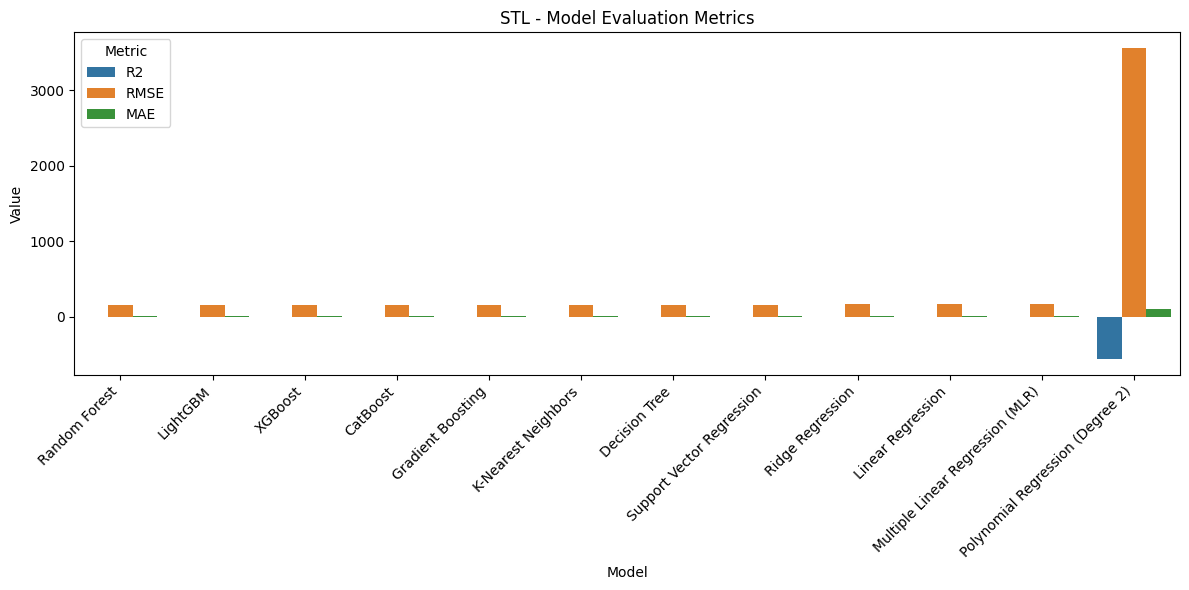

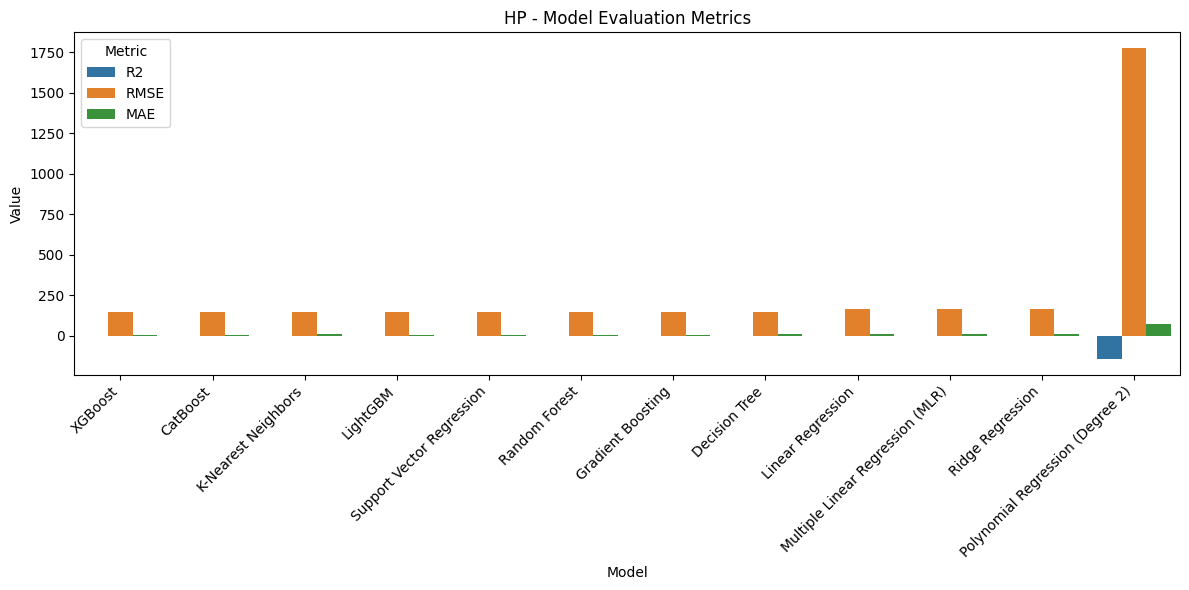

In [28]:
plot_metrics_bar_chart(stl_r2_sorted, "STL")
plot_metrics_bar_chart(hp_r2_sorted, "HP")

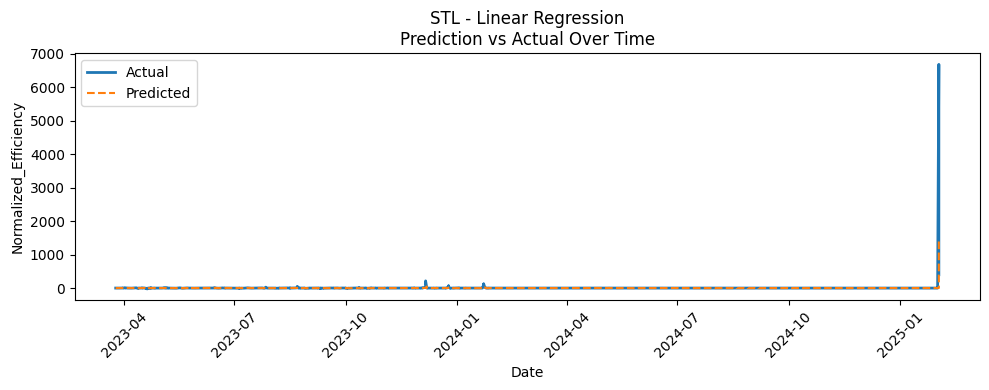

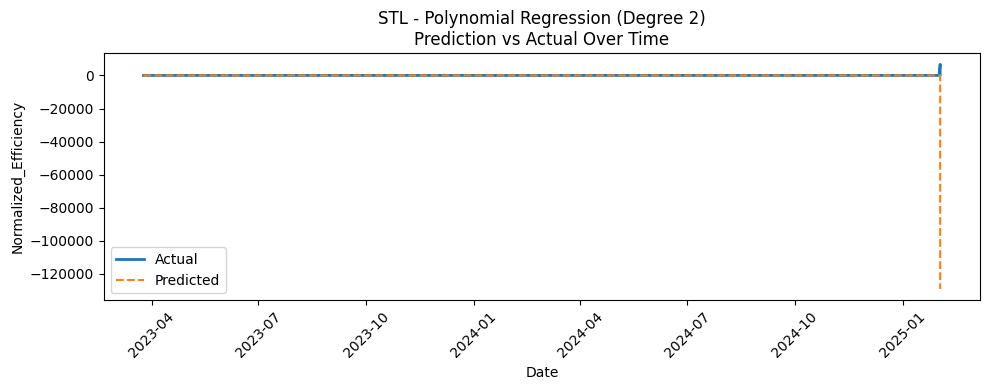

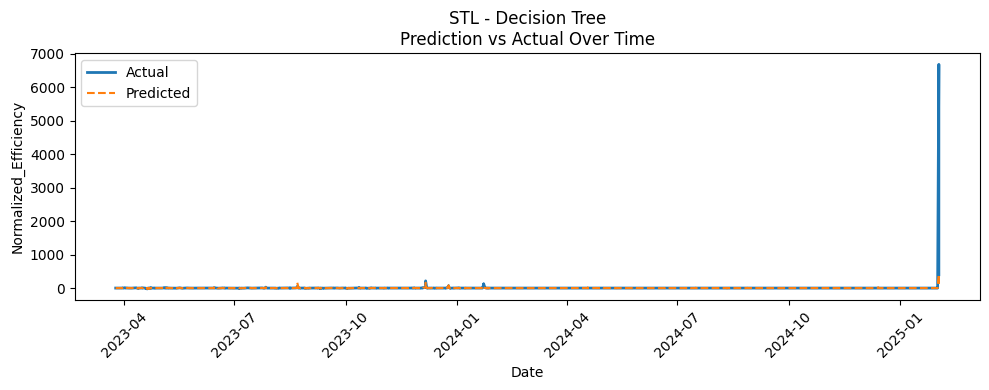

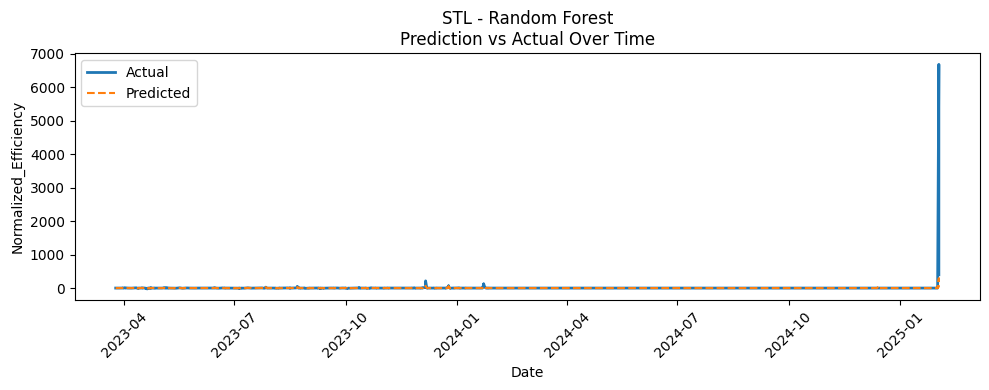

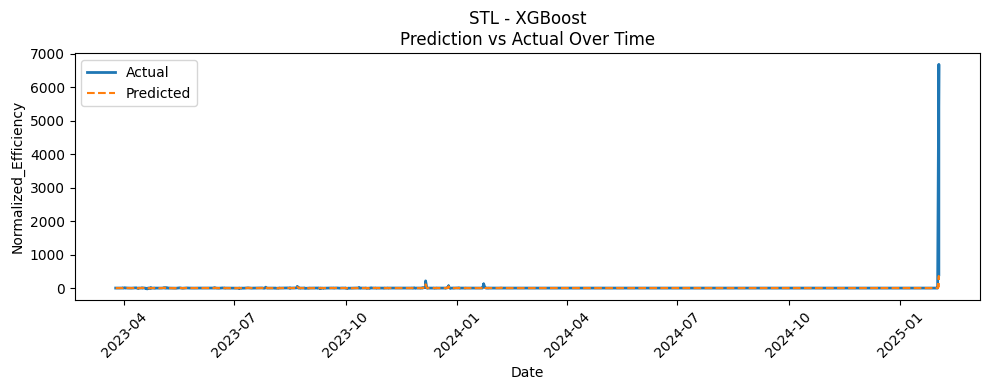

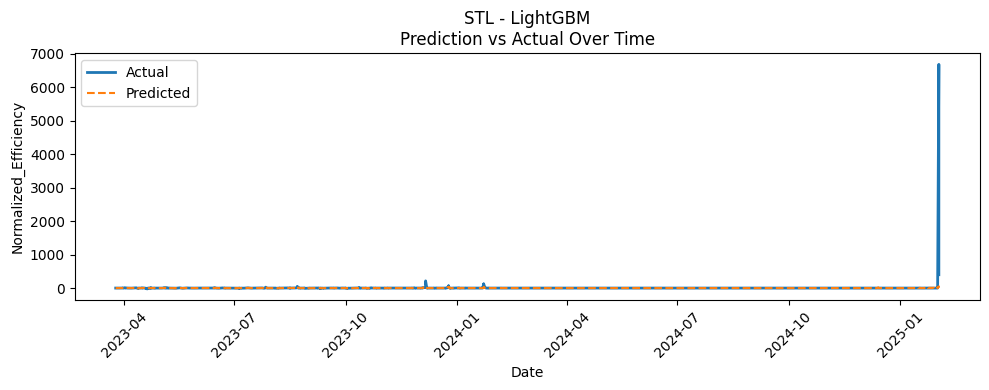

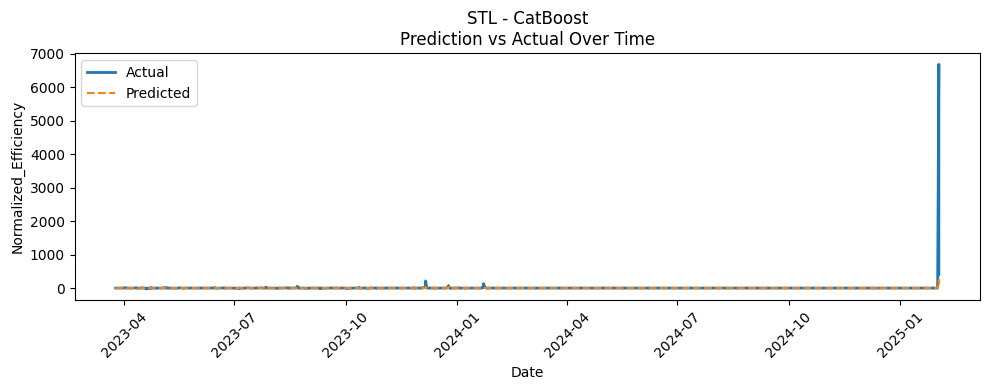

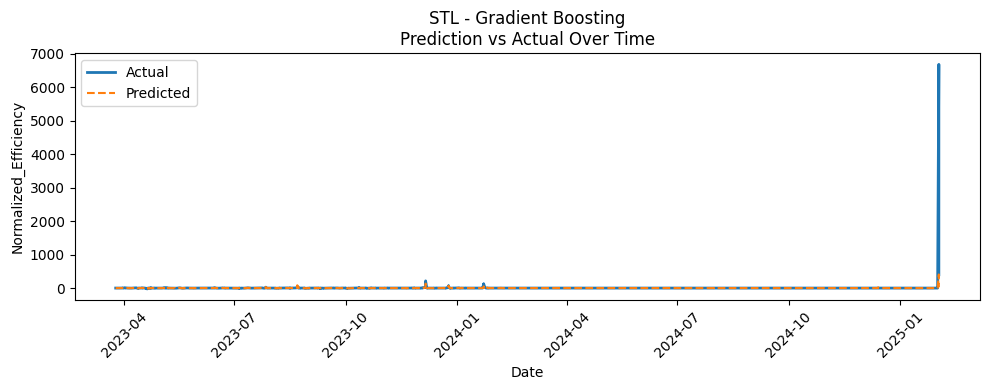

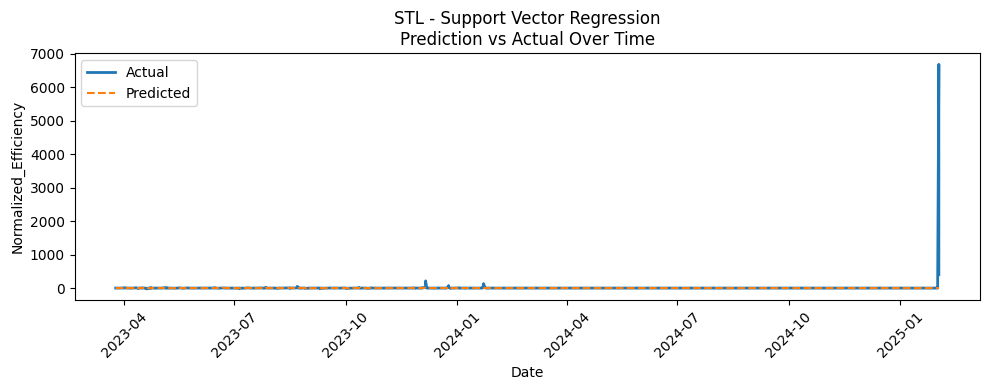

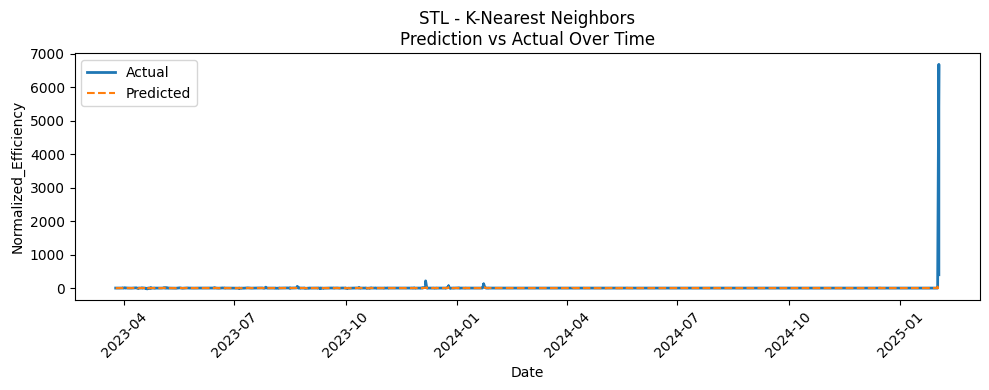

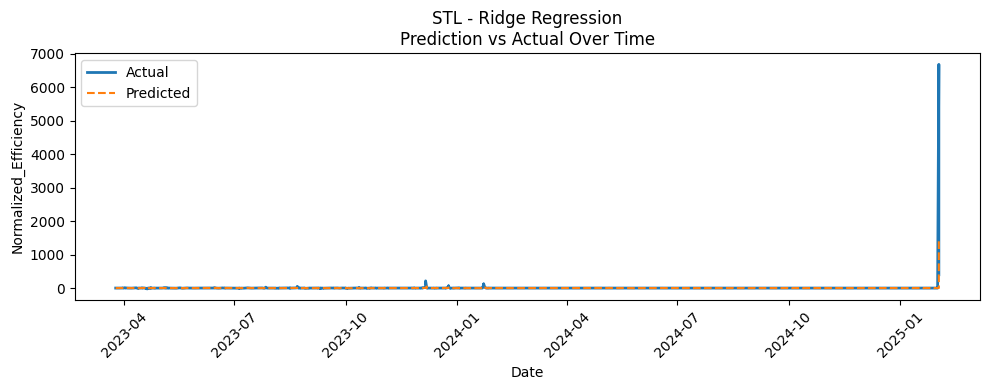

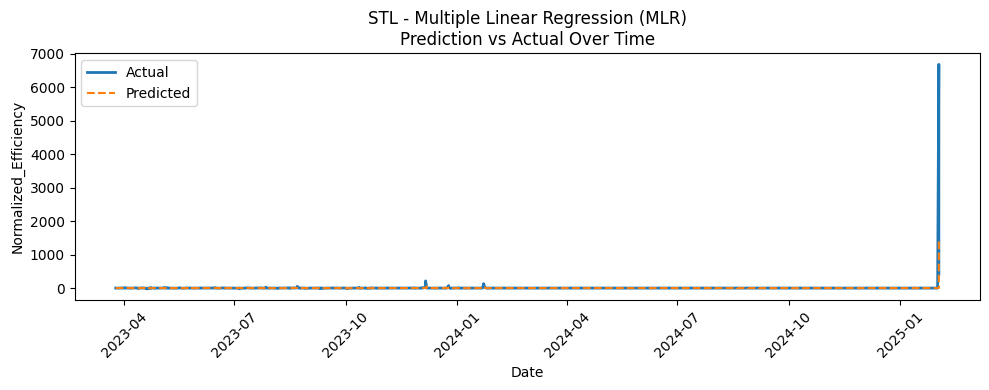

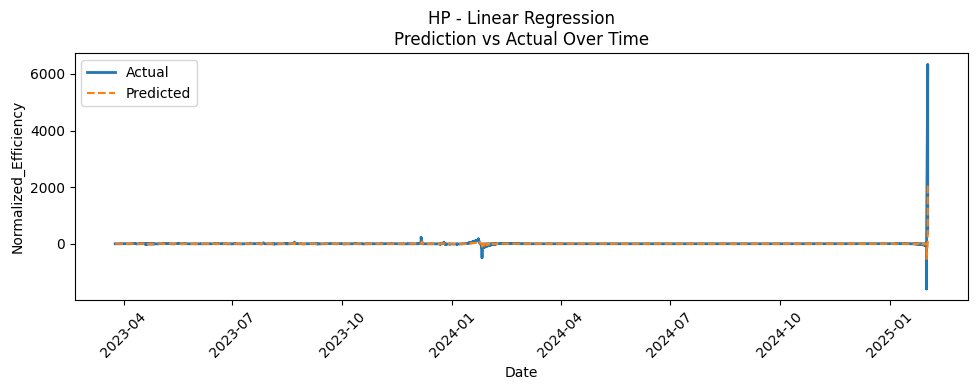

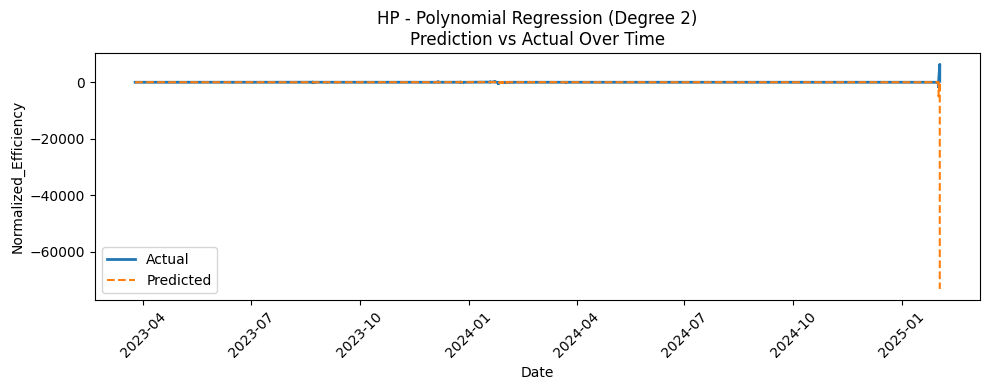

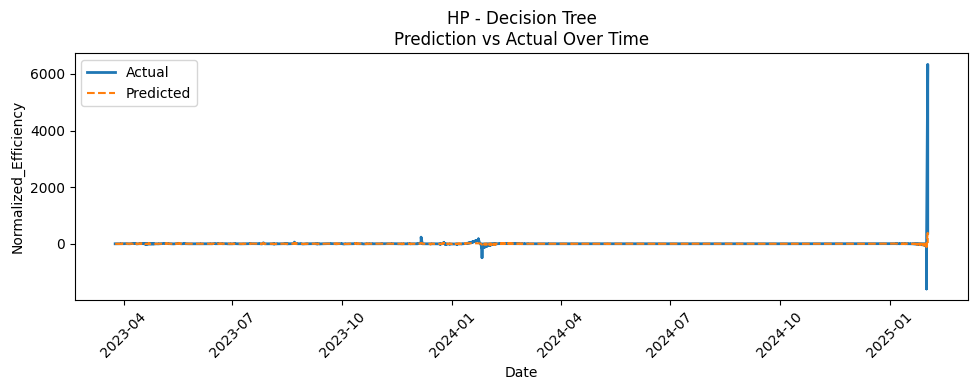

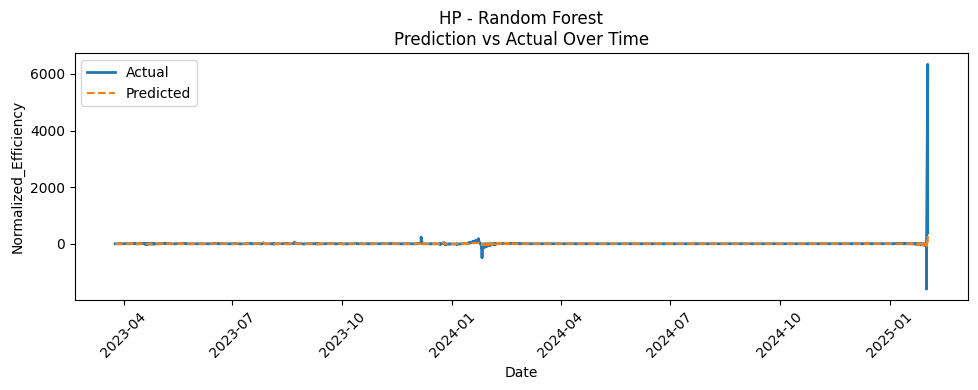

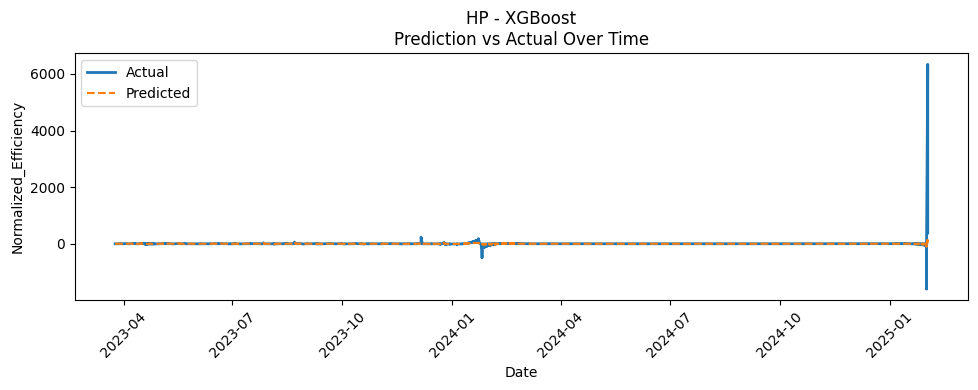

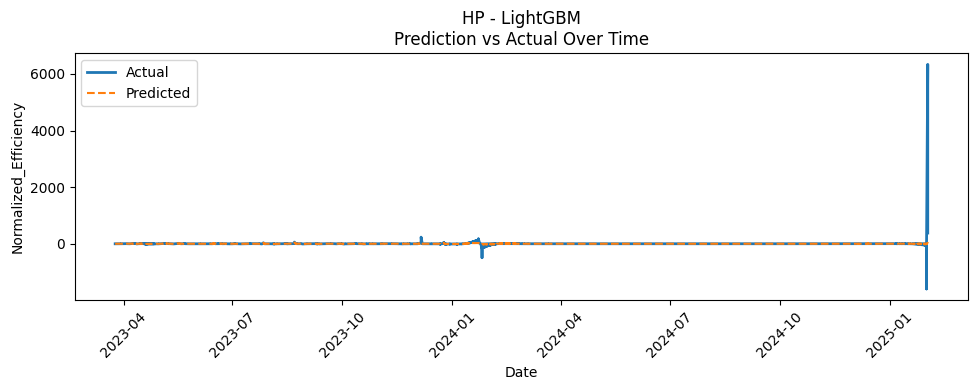

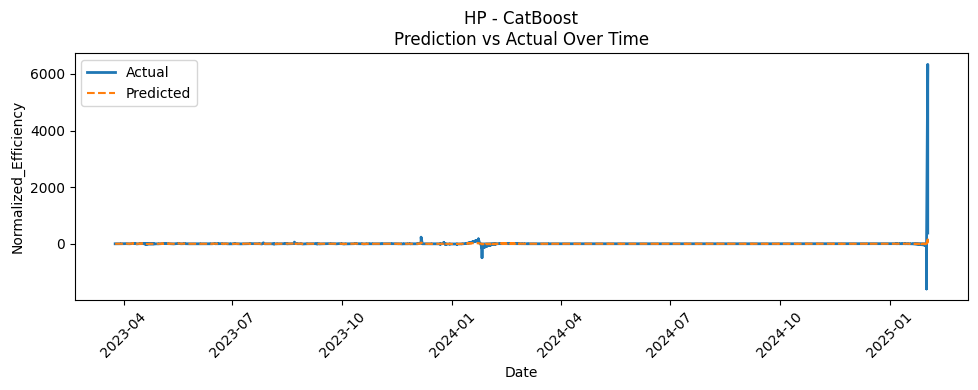

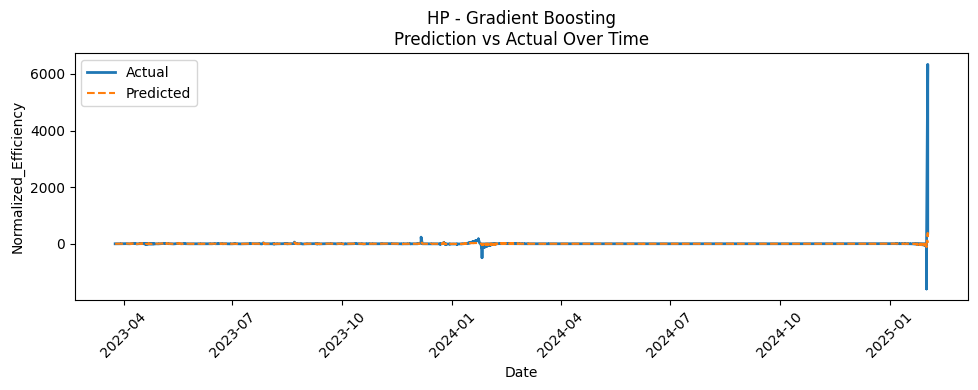

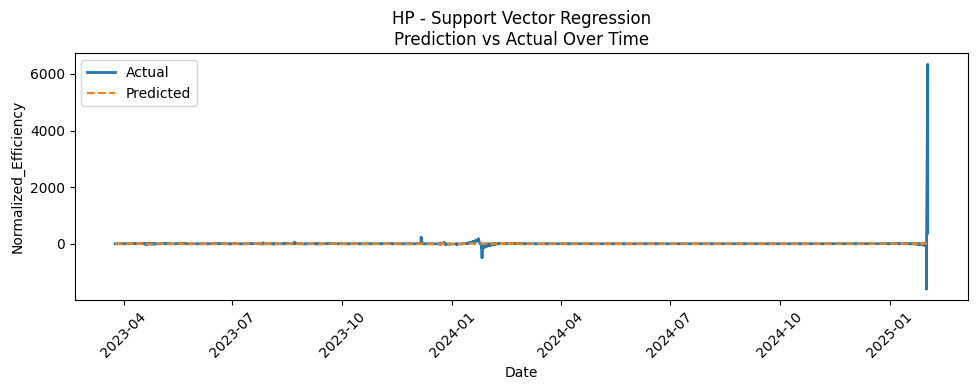

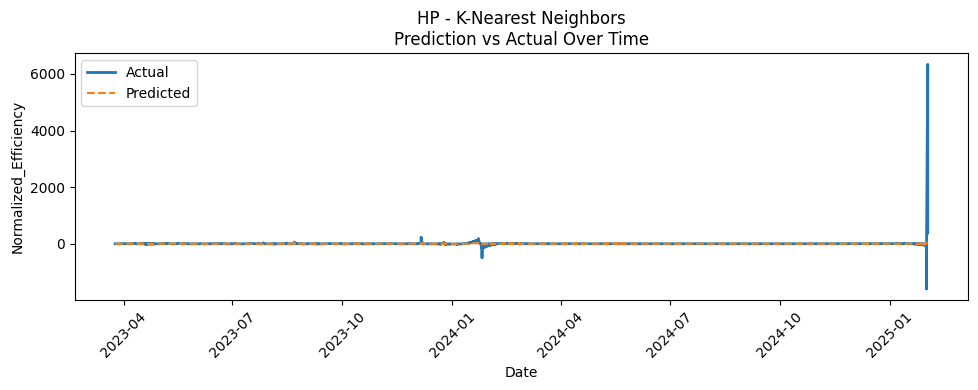

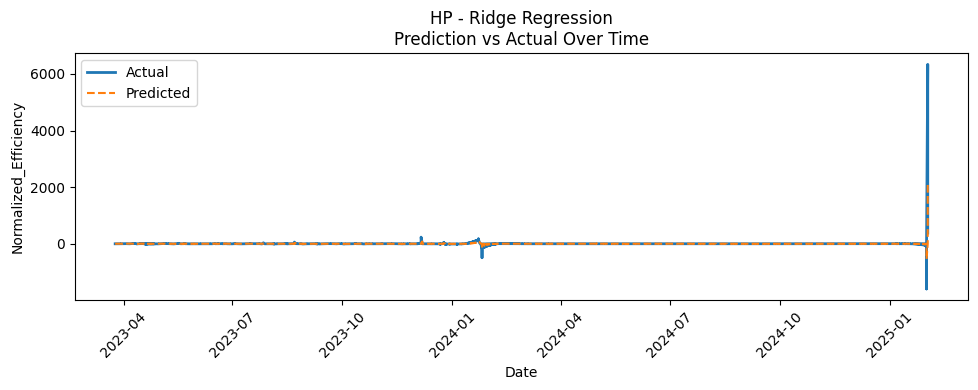

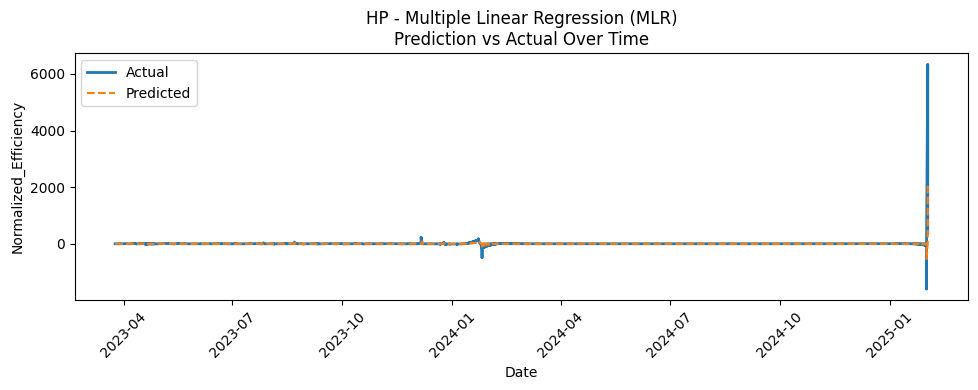

(['stl_catboost_timeseries_pred_vs_actual.png',
  'stl_decision_tree_timeseries_pred_vs_actual.png',
  'stl_gradient_boosting_timeseries_pred_vs_actual.png',
  'stl_k-nearest_neighbors_timeseries_pred_vs_actual.png',
  'stl_lightgbm_timeseries_pred_vs_actual.png',
  'stl_linear_regression_timeseries_pred_vs_actual.png',
  'stl_multiple_linear_regression_mlr_timeseries_pred_vs_actual.png',
  'stl_polynomial_regression_degree_2_timeseries_pred_vs_actual.png',
  'stl_random_forest_timeseries_pred_vs_actual.png',
  'stl_ridge_regression_timeseries_pred_vs_actual.png',
  'stl_support_vector_regression_timeseries_pred_vs_actual.png',
  'stl_xgboost_timeseries_pred_vs_actual.png'],
 ['hp_catboost_timeseries_pred_vs_actual.png',
  'hp_decision_tree_timeseries_pred_vs_actual.png',
  'hp_gradient_boosting_timeseries_pred_vs_actual.png',
  'hp_k-nearest_neighbors_timeseries_pred_vs_actual.png',
  'hp_lightgbm_timeseries_pred_vs_actual.png',
  'hp_linear_regression_timeseries_pred_vs_actual.png',


In [32]:
import matplotlib.dates as mdates
import os

def plot_all_model_predictions_vs_actual(df, dataset_name, target_col, models_dict):
    df = df.drop(columns=["Station"], errors="ignore").dropna()
    df["Date"] = pd.to_datetime(df["Date"])
    dates = df["Date"]
    X = df.drop(columns=[target_col, "Date"])
    y = df[target_col]

    split_index = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    test_dates = dates.iloc[split_index:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models_dict.items():
        if name == "Polynomial Regression (Degree 2)":
            poly = PolynomialFeatures(degree=2)
            X_train_poly = poly.fit_transform(X_train_scaled)
            X_test_poly = poly.transform(X_test_scaled)
            model = LinearRegression()
            model.fit(X_train_poly, y_train)
            y_pred = model.predict(X_test_poly)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

        plt.figure(figsize=(10, 4))
        plt.plot(test_dates, y_test.values, label="Actual", linewidth=2)
        plt.plot(test_dates, y_pred, label="Predicted", linestyle="--")
        plt.title(f"{dataset_name} - {name}\nPrediction vs Actual Over Time")
        plt.xlabel("Date")
        plt.ylabel(target_col)
        plt.legend()
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)
        plt.tight_layout()

        filename = f"../visualizations/{dataset_name.lower()}_{name.lower().replace(' ', '_').replace('(', '').replace(')', '')}_timeseries_pred_vs_actual.png"
        plt.savefig(filename)
        plt.show()
        plt.close()

plot_all_model_predictions_vs_actual(stl_df, "STL", "Normalized_Efficiency", all_models)
plot_all_model_predictions_vs_actual(hp_df, "HP", "Normalized_Efficiency", all_models)

ts_stl_files = sorted([f for f in os.listdir("../visualizations") if f.startswith("stl_") and "timeseries" in f])
ts_hp_files = sorted([f for f in os.listdir("../visualizations") if f.startswith("hp_") and "timeseries" in f])

ts_stl_files, ts_hp_files